In [17]:
# Set up
%pylab inline

# Params
DATADIR = "/storage/mgymrek/gtex-estrs/revision/"
RESULTSDIR = "/storage/mgymrek/gtex-estrs/revision/figures"
GENEANNOT = "/storage/resources/dbase/human/hg19/gencode_gene_annotations_hg19.csv"

# Allow us to edit fonts in Illustrator
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True
from matplotlib.colors import LogNorm

# Import libraries
import os
import pandas as pd
import scipy.stats
import seaborn as sns
import statsmodels.stats.multitest

MIN_CAUSAL_SCORE = 0.3
estrs = pd.read_csv(os.path.join(RESULTSDIR, "SuppTable_CAVIAR.tsv"), sep="\t")
geneannot = pd.read_csv(GENEANNOT)
geneannot["gene"] = geneannot["gene.id"].apply(lambda x: x.split(".")[0])
estrs = pd.merge(estrs, geneannot[["gene", "gene.strand","gene.start","gene.stop"]], on=["gene"])
estrs["motif"] = estrs.apply(lambda x: x["str.motif.forward"] if x["gene.strand"]=="+" else x["str.motif.reverse"], 1)
estrs["dist.tss"] = estrs.apply(lambda x: (x["str.start"]-x["gene.start"]) if x["gene.strand"]=="+" else (x["gene.stop"]-x["str.start"]), 1)

causal = estrs[estrs["score"]>=MIN_CAUSAL_SCORE]

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3.4/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['colors']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


polyT
[253, 7, 10]
[0.525691699604743, 0.2857142857142857, 0.5]
[0.4506540583675878, 0.4531249999999996, 1.0]
polyA
[239, 4, 8]
[0.497907949790795, 0.5, 0.25]
[0.9999999999999639, 1.0, 0.2890624999999999]
all causal
[1420, 51, 86]
[0.5014084507042254, 0.5686274509803921, 0.6046511627906976]
[0.9365497587085088, 0.4010619910279376, 0.06615259746138934]
all strs
[28375, 744, 721]
[0.5053392070484581, 0.478494623655914, 0.5533980582524272]
[0.07299831413588215, 0.25572558368142795, 0.004615805613415762]


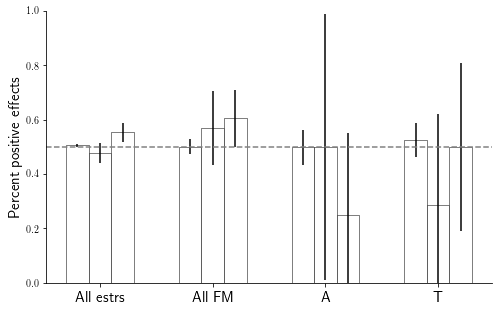

In [18]:
# Effect size bias for homopolymers

labels = []
colors = []
ecolors = []
alphas = []
dirs = []
stderrs = []
nums = []
xvals = []
pvals = []

w = 0.2
udist = 3000
ddist = 3000
tss_bins = [(-10000000, 10000000), (-1*udist, 0), (0, ddist)]
#tss_bins = [(-100000, -50000), (-50000, -10000), (-10000,-3000), (-3000, 0), (0, 3000), (3000,10000), (10000,50000), (50000, 100000)]
binlabels = ["ALL", "promoter", "downstream"]
bincolors = [ "white", "darkgray", "lightgray"]
binalphas = [1, 1, 1]
#binalphas = [1]*len(tss_bins)

def IsARich(x):
    return "A" in x #x.count("A")*1.0/len(x)>0.6

def IsTRich(x):
    return "T" in x # x.count("T")*1.0/len(x)>0.6

polyA = causal[causal["motif"]=="A"]
polyT = causal[causal["motif"]=="T"]
polyAC = causal[(causal["motif"]=="AC")]
polyGT = causal[(causal["motif"]=="GT")]
polyAG = causal[(causal["motif"]=="AG")]
polyCT = causal[(causal["motif"]=="CT")]
polyAT = causal[(causal["motif"]=="AT")]
Arich = causal[(causal["motif"].apply(IsARich))]
Trich = causal[(causal["motif"].apply(IsTRich))]

dfs = [ estrs, causal, polyA, polyT]
classcolors = ["white"]*40
dflabels = ["All estrs", "All FM", "A", "T"]

ind = 0
for df in dfs:
    dflabel = dflabels[ind]
    for tbin in tss_bins:
        l = "tmp"#binlabels[tss_bins.index(tbin)]
        df_bin = df[(df["dist.tss"]>=tbin[0]) & (df["dist.tss"]<tbin[1])]
        perc = np.mean(df_bin["beta"]>0)
        dirs.append(perc)
        if perc < 1:
            stderrs.append(1.96*np.sqrt(perc*(1-perc)/df_bin.shape[0]))
        elif df_bin.shape[0] == 0: stderrs.append(0)
        else:
            stderrs.append(3/df_bin.shape[0])
        nums.append(df_bin.shape[0])
        pvals.append(scipy.stats.binom_test(perc*df_bin.shape[0], df_bin.shape[0]))
    colors.extend([classcolors[ind]]*len(tss_bins))
    alphas.extend(binalphas)
    ind += 1
    xvals.extend([ind+w*i for i in range(len(tss_bins))])
    labels.append(dflabel)
    
rgba_colors = np.zeros((len(xvals), 4))
for i in range(len(colors)):
    rgba_colors[i, 0:3] = matplotlib.colors.to_rgba(colors[i])[0:3]
rgba_colors[:, 3] = alphas

fig = plt.figure()
fig.set_size_inches((8, 5))
ax = fig.add_subplot(111)
ax.bar(xvals, dirs, color=rgba_colors, edgecolor="black", linewidth=0.5, yerr=stderrs, ecolor="black",  width=w)
ax.axhline(y=0.5, linestyle="dashed", color="gray")
ax.set_ylim(bottom=0, top=1);
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xticks([xvals[i] for i in range(len(xvals)) if i%3 == 1])
ax.set_xticklabels(labels, size=15);
ax.set_ylabel("Percent positive effects", size=15);
#fig.savefig(os.path.join(RESULTSDIR, "%s_ATDirection.pdf"%FIGPREFIX))

print("polyT")
print(nums[9:12])
print(dirs[9:12])
print(pvals[9:12])

print("polyA")
print(nums[6:9])
print(dirs[6:9])
print(pvals[6:9])

print("all causal")
print(nums[3:6])
print(dirs[3:6])
print(pvals[3:6])

print("all strs")
print(nums[0:3])
print(dirs[0:3])
print(pvals[0:3])

/usr/lib/python3.4/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


0.06542968749999997
0.9999999999999997
0.09313964843749999
0.8679394004284399
0.7428293587290689
0.6439689563703725
0.1262894743854302
0.5423840118564844
0.6776394844055175
0.6476058959960938


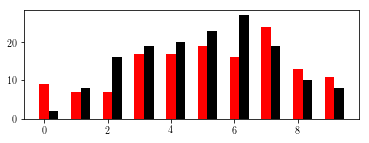

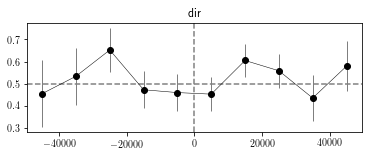

In [19]:
w = 10000
distbins = np.arange(-50000, 50000+w, w)
usecol = "dist.tss"

nucdata = []

cdata = estrs[estrs["score"]>=MIN_CAUSAL_SCORE]
cdata["len"] = cdata["str.end"]-cdata["str.start"]+1
for xx in [cdata[cdata["motif"].apply(lambda x: x in ["A"])], cdata[cdata["motif"].apply(lambda x: x in ["T"])], cdata[cdata["motif"].apply(lambda x: x in ["A","T"])]]:
    dirs = []
    dirps = []
    direrrs = []
    betas = []
    betaerrs = []
    dists = []
    strands = []
    strandps = []
    stranderrs = []
    lens = []
    lenerrs = []
    dnase = []
    dnaseerrs = []
    nums = []
    for d in range(len(distbins)-1):
        lb = distbins[d]
        ub = distbins[d+1]
        x = xx[(xx[usecol]>=lb) & (xx[usecol]<ub)].copy()
        dird = np.array((x["beta"]>0).apply(int))
        dirs.append(np.mean(dird))
        dirps.append(scipy.stats.binom_test(sum(dird), len(dird)))
        direrrs.append(np.sqrt(np.var(dird)/len(dird)))
        betas.append(np.mean(x["beta"].apply(abs)))
        try:
            betaerrs.append(np.sqrt(np.var(x["beta"])/x.shape[0]))
        except: betaerrs.append(np.nan)
        dists.append(np.mean(x["dist.tss"].apply(abs)))
        s = np.array((x["motif"]=="A").apply(int))
        strands.append(np.mean(s))
        strandps.append(scipy.stats.binom_test(sum(s), len(s)))
        stranderrs.append(np.sqrt(np.var(s)/len(s)))
        lens.append(np.mean(x["len"]))
        try:
            lenerrs.append(np.sqrt(np.var(x["len"])/x.shape[0]))
        except: lenerrs.append(np.nan)
        nums.append(x.shape[0])
    nd = pd.DataFrame({"dir": dirs, \
             "dir.p": dirps, \
             "beta": betas, \
             "dist.tss": dists, \
             "strand": strands, \
             "strand.p": strandps, \
                 "dir.err": direrrs, \
                 "beta.err": betaerrs, \
                 "strand.err": stranderrs, \
                      "len": lens, \
                      "len.err": lenerrs, \
                      "num": nums})
    nucdata.append(nd)
    
siglabels = []
for i in range(len(nucdata[0]["num"])):
    x1 = nucdata[0]["num"][i]
    x2 = nucdata[1]["num"][i]
    print(scipy.stats.binom_test(x1, x1+x2))

fig = plt.figure()
fig.set_size_inches((6, 2))
ax = fig.add_subplot(111)
ax.bar(range(nucdata[0].shape[0]), list(nucdata[0]["num"]), color="red", width=0.3)
ax.bar([item+0.3 for item in range(nucdata[0].shape[0])], list(nucdata[1]["num"]), color="black", width=0.3)

for col in ["dir"]:     
    fig = plt.figure()
    fig.set_size_inches((6, 2))
    ax = fig.add_subplot(111)
    ax.errorbar(distbins[:-1]+w/2, nucdata[2][col], yerr=nucdata[2]["%s.err"%col], color="black", marker="o", linewidth=0.5)
    if col in [ "dir","strand"]: ax.axhline(y=0.5, linestyle="dashed", color="gray")
    if col == "beta": ax.axhline(y=np.mean(causal["beta"].apply(abs)), color="gray", linestyle="dashed")
    ax.axvline(x=0, linestyle="dashed", color="gray")
    ax.set_title(col)
    

In [20]:
d = cdata[(cdata["motif"]=="T") & (cdata["dist.tss"]>0)].sort_values("beta").copy()